<center><h1>Retrieval Augmented Generation (RAG) chatbot <br>
    on a custom PDF dataset with Gradio UI</h2></center>

<img src="images/RAG-diagram-dell-technologies.png" alt="Alternative text" />

### Summary

- Retrieval augmented generation (RAG) is a method of augmenting the vectors of a model with the contents of a vector database created from custom content like documents and pdf files.  This is a very fast, low impact method that combines proven off the shelf models (Llama2 in this case) with your custom documents, providing a human-like response to questions based on the content in your document repo.
- RAG details: https://docs.langchain.com/docs/use-cases/qa-docs
- Llama2 details: https://huggingface.co/docs/transformers/main/model_doc/llama2

- This does not require time-consuming training runs since the contents of the documents are embedded in a vector database that is outside the model and none of the model weights are being modified.

- The vector database (Chromadb) in this case can be created and stored on prem and placed in block storage if necessary 

- This can all be updated real-time, allowing users to view the latest ground truth documents from your repo

- Example pdf documents were downloaded and stored on the host that the notebook server was running on.  Documents are from Dell Technologies Infohub https://infohub.delltechnologies.com/
- Gradio is used to provide a front end GUI to provide conversational chat with chat history


### Prerequisites
- permission from Meta to use Llama-2 model  https://ai.meta.com/resources/models-and-libraries/llama-downloads/
- install poppler utils:  sudo apt-get install poppler-utils
- huggingface API token with write capability, insert into hugging face login token variable below
- pdf folder of files at the same file structure level as this notebook, "pdfs-dell-infohub", change the name as needed on your local host.
- pdf files inside folder as training content


### Notes
- Click Run -> Run all Cells to begin
- If it fails with CUDA out of memory, simply go to top navigation menu Kernel-> Restart Kernel and Clear output.  Then Run -> Run All Cells again.
- Tested successfully on Ubuntu 22.04 with Nvidia T4 GPU

### Install python libraries and applications

In [1]:
## code to auto login to hugging face, avoid the login prompt

## your hugging face hub version has a lot of libraries that are used throughout.  Try to solve any dependencies with this if you experience errors. 
#import sys
#!{sys.executable} -m pip install --force-reinstall huggingface-hub==0.16.4 

%pip install huggingface-hub==0.16.4

# get your account token from https://huggingface.co/settings/tokens
token = 'XXXXXXXXXXXXXXXXXX'

from huggingface_hub import login
login(token=token, add_to_git_credential=True)

Note: you may need to restart the kernel to use updated packages.
Token is valid (permission: write).
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /home/demouser/.cache/huggingface/token
Login successful


In [2]:
#!pip install -U pip
%pip install torch
%pip install transformers
%pip install langchain
%pip install chromadb
%pip install pypdf
%pip install xformers
%pip install sentence_transformers
%pip install InstructorEmbedding
%pip install pdf2image
%pip install pycryptodome
%pip install cython cchardet

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### Install quantization package for LLM
For more details https://github.com/PanQiWei/AutoGPTQ

In [3]:
%pip install auto-gptq --extra-index-url https://huggingface.github.io/autogptq-index/whl/cu118/

Looking in indexes: https://pypi.org/simple, https://huggingface.github.io/autogptq-index/whl/cu118/
Note: you may need to restart the kernel to use updated packages.


### Import libraries

In [4]:
import torch
from auto_gptq import AutoGPTQForCausalLM
from langchain import HuggingFacePipeline, PromptTemplate
from langchain.chains import RetrievalQA
from langchain.document_loaders import PyPDFDirectoryLoader
from langchain.embeddings import HuggingFaceInstructEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from pdf2image import convert_from_path
from transformers import AutoTokenizer, TextStreamer, pipeline



### Assign single GPU to device variable

This command assigns GPU ID 0 to the DEVICE variable called "cuda:0" if pytorch can actually reach and speak with the GPU using cuda language.  Else it will use the cpu.

In [5]:
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

### Clear GPU memory from any previous runs
- assume Nvidia drivers installed
- When running notebooks over and over again, often much of the memory is still in the GPU memory allocated cache.  Depending on the size of the GPU, this might cause out of memory issues during the next run.  It is advised to clear out the cache, or restart the kernel.
- here we see multiple GPUs, the memory usage, any running processes and our CUDA version

In [6]:
!nvidia-smi

Tue Dec 19 18:44:06 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA H100 PCIe               Off | 00000000:0D:00.0 Off |                    0 |
| N/A   39C    P0              49W / 350W |      7MiB / 81559MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Clear the previous run vector database

This is optional, the vector db will be rebuilt.  For a completely fresh run you can delete the local folder.

In [8]:
## remove chroma vector db local db folder from previous run

!rm -rf "db"

### Preview some of the PDF files

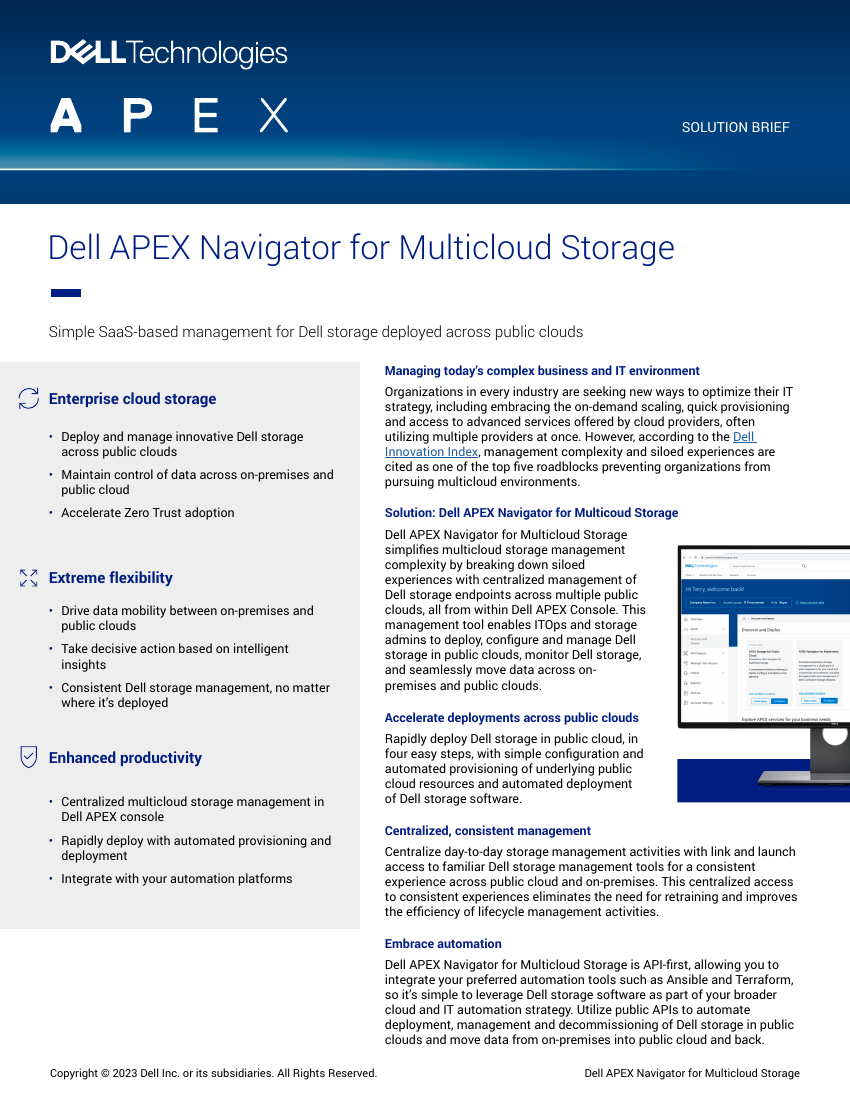

In [9]:
pdf_images = convert_from_path("pdfs-dell-infohub/apex-navigator-for-multicloud-storage-solution-overview.pdf", dpi=100)
pdf_images[0]

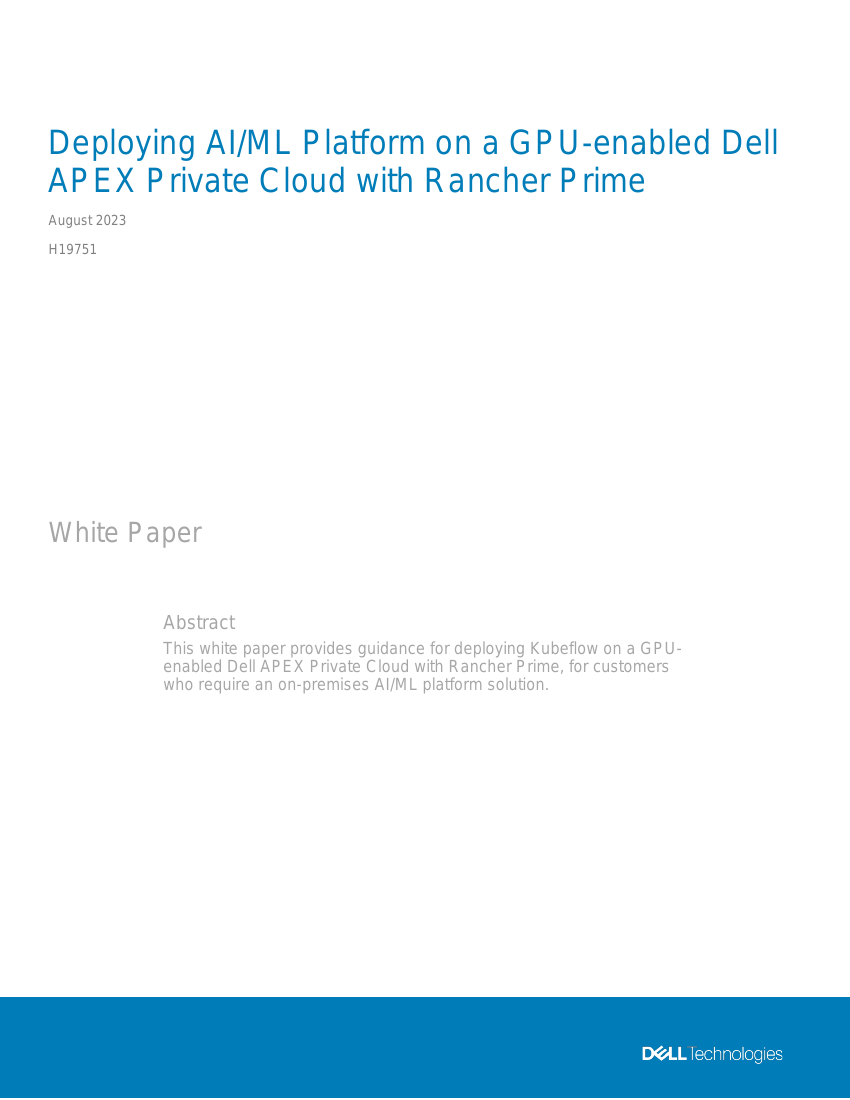

In [10]:
pdf_images = convert_from_path("pdfs-dell-infohub/h19751-aiml-platform-on-a-gpu-enabled-dell-apex-private-cloud-with-rancher-prime.pdf", dpi=100)
pdf_images[0]

### Load PDF documents as individual pages
- loader directory can be modified to suit your environment
- the command will look for a directory in the same path where the notebook is located
- this document directory and the files must be present before the run
- in this case we downloaded 40 pdf files.  The loader loads all of the pages associated with those files and offers what amounts to a page count.
- This process does not hit the GPU, should be optimized as it takes awhile.

In [11]:
loader = PyPDFDirectoryLoader("pdfs-dell-infohub")
docs = loader.load()
len(docs)

2840

### Use Huggingface Instructor model for content vector embeddings

- An instruction-finetuned text embedding model that can generate text embeddings tailored to any task
- https://huggingface.co/hkunlp/instructor-large
- this will be used to feed vectorized versions of our PDF content into the vector database

In [12]:
embeddings = HuggingFaceInstructEmbeddings(
    model_name="hkunlp/instructor-large", model_kwargs={"device": DEVICE}
)

load INSTRUCTOR_Transformer
max_seq_length  512


### Split our content into chunks
- Text splitting controls the granularity of chunks of text.  A smaller chunk size results in smaller chunks, but more of them.
- If you want more granular output from highly structured content, like code, you would need to make chunks smaller.
- If you are looking for output that contains whole sentences, like written text, then a larger chunk size works better. 
- Chunk overlap is the number of characters that should overlap between two adjacent chunks.
- https://python.langchain.com/docs/modules/data_connection/document_transformers/text_splitters/recursive_text_splitter

In [13]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=32)
texts = text_splitter.split_documents(docs)
len(texts)

11095

### Create content vector database on prem using Chroma db
- Parses pdf content into chunked encoded embeddings  https://www.trychroma.com/
- This is a sqlite db created in a local "db" folder in the same directory as this notebook
- This process takes a couple of minutes
- This process will use the GPU

In [14]:
## takes a few minutes
vectordb = Chroma.from_documents(texts, embeddings, persist_directory="db")

### Llama-2  13 Billion parameter base pre-trained model
- pre-quantized model for memory optimimization
- requires at least 14Gb GPU memory
- https://huggingface.co/TheBloke/Llama-2-13B-chat-GPTQ
- gptq-4bit-128g-actorder_True   on a single T4 GPU, 4 bit is recommended.  If you want to run 8 bit you'll need more than 16Gb of GPU memory.

In [15]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GPTQ"
#model_name_or_path = "TheBloke/Llama-2-7B-chat-GPTQ"
model_basename = "model"

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)

model = AutoGPTQForCausalLM.from_quantized(
    model_name_or_path,
    revision="gptq-4bit-128g-actorder_True",
#    revision="gptq-4bit-32g-actorder_True",
    model_basename=model_basename,
    use_safetensors=True,
    trust_remote_code=True,
    inject_fused_attention=False,
    device=DEVICE,
    quantize_config=None,
)

Skipping module injection for FusedLlamaMLPForQuantizedModel as currently not supported with use_triton=False.


### Stream text responses to screen

In [16]:
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

### Interact with the model directly using Huggingface pipelines
- Huggingface pipeline library allows you to directly access the model with queries
- https://huggingface.co/docs/transformers/pipeline_tutorial
- do_sample: if set to True, this parameter enables decoding strategies such as multinomial sampling, beam-search multinomial sampling, Top-K sampling and Top-p sampling. All these strategies select the next token from the probability distribution over the entire vocabulary with various strategy-specific adjustments.

In [17]:
text_pipeline = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=1024,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=1.15,
    streamer=streamer,
)

The model 'LlamaGPTQForCausalLM' is not supported for text-generation. Supported models are ['BartForCausalLM', 'BertLMHeadModel', 'BertGenerationDecoder', 'BigBirdForCausalLM', 'BigBirdPegasusForCausalLM', 'BioGptForCausalLM', 'BlenderbotForCausalLM', 'BlenderbotSmallForCausalLM', 'BloomForCausalLM', 'CamembertForCausalLM', 'LlamaForCausalLM', 'CodeGenForCausalLM', 'CpmAntForCausalLM', 'CTRLLMHeadModel', 'Data2VecTextForCausalLM', 'ElectraForCausalLM', 'ErnieForCausalLM', 'FalconForCausalLM', 'FuyuForCausalLM', 'GitForCausalLM', 'GPT2LMHeadModel', 'GPT2LMHeadModel', 'GPTBigCodeForCausalLM', 'GPTNeoForCausalLM', 'GPTNeoXForCausalLM', 'GPTNeoXJapaneseForCausalLM', 'GPTJForCausalLM', 'LlamaForCausalLM', 'MarianForCausalLM', 'MBartForCausalLM', 'MegaForCausalLM', 'MegatronBertForCausalLM', 'MistralForCausalLM', 'MptForCausalLM', 'MusicgenForCausalLM', 'MvpForCausalLM', 'OpenLlamaForCausalLM', 'OpenAIGPTLMHeadModel', 'OPTForCausalLM', 'PegasusForCausalLM', 'PersimmonForCausalLM', 'PLBartFo

In [18]:
llm = HuggingFacePipeline(pipeline=text_pipeline, model_kwargs={"temperature": 0.7})

### Prompt template
- building a prompt template helps the model to better understand our question and frame the type of response we want.
- without a prompt template, the LLM can only be guided by the question, and that will not produce a well-formatted, full response.  We want to enable the LLM to give us the desired format by instructing it how to respond.
- the two prompts here tell it how to behave, and then tell it how to respond to the question.
- the function combines both prompts.

In [19]:
DEFAULT_SYSTEM_PROMPT = """
You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe. Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.

If a question does not make any sense, or is not factually coherent, explain why instead of answering something incorrectly. If you don't know the answer to a question, please don't share false information.
""".strip()


def generate_prompt(prompt: str, system_prompt: str = DEFAULT_SYSTEM_PROMPT) -> str:
    return f"""
[INST] <<SYS>>
{system_prompt}
<</SYS>>

{prompt} 

[/INST]
""".strip()

In [20]:
SYSTEM_PROMPT = "Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer."

template = generate_prompt(
    """
{context}

Question: {question}

""",
    system_prompt=SYSTEM_PROMPT,
)

In [21]:
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

### Use Langchain library to link and retrieve similar document chunks from vectordb
- document content was chunked and vectorized and placed into the vector db
- here we will take the question, rank its similarity to the chunks of content, and retrieve those similar chunks
- the highest ranking, most similar chunks will be fed to the LLM along with the question

In [22]:
qa_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=vectordb.as_retriever(search_kwargs={"k": 2}),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt},
)

### Prompts and responses
- Now let's ask it some questions.
- Questions will be fed to the chain, chunked data that is similar will be collected and then passed in the chain to the LLM for a response that is framed within our prompt template.

### Brief file list of includes PDFs
Use the titles of these pdfs as a guide to ask questions from that custom dataset
- apex-navigator-kubernetes-solution-brief.pdf
- apex-protection-storage-sb.pdf
- APEX-VDI-vs-Amazon-WorkSpaces-performance-science.pdf
- dell-technologies-apex-vsphere-tanzu-validation-whitepaper.pdf
- Exec Summary 2023 Dell Edge Computing for Retail MX750 vs MX760.pdf
- powerscale-cloudpools-and-microsoft-azure-wp.pdf
- powerscale-cloudpools-and-aws-wp.pdf
- powerscale-cloudpools-and-google-cloud-wp.pdf
- powerflex-introduction-to-replication-wp.pdf
- dell-powerflex-maintenance-modes.pdf

### Prompt #1

In [23]:
%%time
result = qa_chain("Does apex block storage support multiple availability zones?")
print('\n' + 'Time to complete:')

 Based on the information provided, yes, APEX Block Storage does support multiple availability zones. It has the ability to spread data across multiple availability zones, ensuring data access even in the event of an availability zone failure.

Time to complete:
CPU times: user 2.07 s, sys: 328 ms, total: 2.4 s
Wall time: 2.39 s


### source content location in original PDF

In [24]:
print(result["source_documents"][0].page_content)

of data or needing to use replication across AZs.  Leveraging the native fault sets feature, data is distributed across three or more 
availability zones to offer additional protection against AZ failure.  
  
Well Suited for Challenging Workloads  
APEX Block Storage provides proven enterprise data services, such as thin provisioning, snapshots, replication , volume migration,  and


### Prompt #2

In [25]:
%%time
result = qa_chain("provide a curl example of code to authenticate my powerflex")
print('\n' + 'Time to complete:')

 Based on the information provided, here is an example of how to use `curl` to authenticate with a PowerFlex gateway or manager using the `Basic` authentication method:
```bash
curl -X GET \
 https://<PowerFlex_Gateway>/api/login \
 -H 'Accept: application/json' \
 -H 'Authorization: Basic < bases64 encoded username and password >'
```
Replace `<PowerFlex_Gateway>` with the hostname or IP address of your PowerFlex device, and `<bases64 encoded username and password>` with the base64 encoded credentials of your PowerFlex account.

Note: You can use the `base64` command to encode your username and password before passing them in the `Authorization` header. For example:
```bash
curl -X GET \
 https://<PowerFlex_Gateway>/api/login \
 -H 'Accept: application/json' \
 -H 'Authorization: Basic '$(base64 -w0 < username:password )
```
This will send the base64 encoded credentials in the `Authorization` header.

I hope this helps! Let me know if you have any further questions.

Time to complete:

### source content location in original PDF

In [26]:
print(result["source_documents"][0].page_content)

Authentication  
 
11 PowerFlex REST API Introduction  
Foundation for Automation  
 Python example  
import requests  
import json  
import getpass  
import urllib3  
 
#Authentication function saved as pfauth.py.  
def authenticate(username, password):  
  url = 'https:// pfxm.powerflex.lab/rest/auth/login'  
  payload = json.dumps({  
  'username': f'{username}',  
  'password': f'{password}'  
  }) 
  headers = {  
  'Content -Type': 'application/json',  
  'Accept': 'application/json'  
  }


### Prompt #3

In [27]:
%%time
result = qa_chain("do you have any suggestions for which GPU to use for AI?")
print('\n' + 'Time to complete:')

 Based on the information provided in the text, there is no direct suggestion for a specific GPU to use for AI. The text only mentions that GPUs are used for AI and ML workloads and that they should be selected based on the specific needs of the organization. However, it does mention NVIDIA as a provider of GPUs for AI and ML workloads. It might be beneficial to research different GPU options and their respective strengths and weaknesses before making a decision.

Time to complete:
CPU times: user 3.95 s, sys: 312 ms, total: 4.26 s
Wall time: 4.25 s


### source content location in original PDF

In [28]:
print(result["source_documents"][0].page_content)

How we tested
Artificial intelligence (AI) and ML workloads rely heavily 
on computing speed. Organizations that want faster AI 
or ML workload performance can use GPUs in addition 
to CPUs because GPUs offer extreme parallelization and 
matrix math capabilities. Organizations may run GPU-
based workloads on bare-metal configurations to avoid the 
possibility of hypervisor or virtualization overheads. For those 
compute-heavy workloads, IT staff configure optimization,


### Gradio UI

- Gradio is a quick, highly customizable UI package for your python applications:  https://www.gradio.app/
- Combined with langchain, gradio can trigger multiple chains for a wide variety of user interactions.

In [29]:
%pip install langchain gradio

Note: you may need to restart the kernel to use updated packages.


### Create new conversational retrieval chain for Gradio
To create a conversational chat vs. a single one shot question / answer session, you need to set give the bot a form of memory to remember the content within the chat session.  This utilizes another langchain tool called "ConversationalRetrievalChain".  Previously we only used the Retrieval QA chain.

In [30]:
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationBufferWindowMemory


conv_chain = ConversationalRetrievalChain.from_llm(
    llm=llm,
    combine_docs_chain_kwargs={"prompt": prompt},
    retriever=vectordb.as_retriever(search_kwargs={"k": 2}),
    chain_type="stuff",
    return_source_documents=True,
#    memory=ConversationBufferMemory(memory_key='chat_history', return_messages=True, input_key="question", output_key='answer'),   

    #### use buffer window memory, set key to number of interactions in the history to remain - pay attention to
    memory=ConversationBufferWindowMemory(k=5, memory_key='chat_history', return_messages=True, input_key="question", output_key='answer'),   

    get_chat_history=lambda h : h,
)

### Build the Gradio GUI
The user class is created and contains the response trigger that sends the user question along with the chat history to the LLM for processing. 

#### Access the UI
- The provided code forces Gradio to create a small web server on the local host the notebook is being served from
- Gradio will provide a URL that can be used in a web browser, that must be accessed from within the same network, so you may need to access it using a jumphost.  In this case we used a Windows jump host and Chrome browser on the same network to access the page.

In [ ]:
import gradio as gr
import os
import time

### define our classes

with gr.Blocks() as demo:


########### TITLE ############

    gr.Markdown(
    """
    # Digital Assistant Chatbot
    """)

########### DEFINE DIALOGUE SCREEN ############

    chatbot = gr.Chatbot(
        bubble_full_width=False,
        avatar_images=(None, (os.path.join(os.path.dirname("__file__"), "images/dell-logo-sm.jpg"))),
    )


########### DEFINE VOTING ############
    
    def vote(data: gr.LikeData):
        if data.liked:
            print("You upvoted this response: " + data.value)
        else:
            print("You downvoted this response: " + data.value)

    chatbot.like(vote, None, None)  # Adding this line causes the like/dislike icons to appear in your chatbot

########### DEFINE USER ############

    def user(user_message, history):
        # Get response from QA chain
        response = conv_chain({"question": user_message, "chat_history": history})
        # Append user message and response to chat history
        history.append((user_message, response["answer"]))
#        history.append((user_message, response["answer"], response["source_documents"][0]))
        return gr.update(value=""), history

########### DEFINE SOURCE DOCS ############

#    def source_docs(source_output):
#        return result["source_documents"][0].page_content

########### BUILD SOURCE DOCS OUTPUT TEXT BOX ############
#
#    with gr.Row():
#        source_output = gr.Textbox(label="Source docs")
        
########### BUILD INPUT TEXT BOX ############

    
    with gr.Row():
            msg = gr.Textbox(
                scale=4,
                placeholder="Input text or click an example button below, then press enter",
                container=False,
            )
            submit_btn = gr.Button('Submit')
            submit_btn.click(user, inputs=[msg, chatbot], outputs=[msg, chatbot], queue=False)

########### EXAMPLE PROMPT AREA ############

    
    gr.Examples([["Please summarize what Dell PowerScale Cloudpools are."],
                 ["List 3 solutions Dell Technlogies provides for the Telecom industry."],
                 ["Tell me more about Dell Native Edge software solutions."]], inputs=[msg])

    
########### BUILD CLEAR BUTTON ############

    clear = gr.Button("Clear")
    clear.click(lambda: None, None, chatbot, queue=False)


########### CHAT HISTORY EMPTY ARRAY ############

    chat_history = []

########### INITIALIZE SERVER WITH PARAMETERS ############

if __name__ == "__main__":
    demo.queue(max_size=10)  ## sets up websockets for bidirectional comms and no timeouts, set a max number users in queue
    demo.launch(share=False, debug=True, server_name="172.16.6.3", server_port=7861, allowed_paths=["images/dell-logo-sm.jpg"])

Running on local URL:  http://172.16.6.3:7861

To create a public link, set `share=True` in `launch()`.


### Take aways from this example

- prompt/completion lookup and output varies depending on the question, anywhere from 2 to 7 seconds in this example. 
- embedding the vector database takes several minutes
- responses are useful and do not suffer from hallucinations
- responses are backed up by source data

## References
- Code example for this notebook and others at:  https://github.com/dell-examples
- Dell Technologies Infohub:  https://infohub.delltechnologies.com/
- Original inspiration repo:  https://github.com/curiousily/Get-Things-Done-with-Prompt-Engineering-and-LangChain
- Meta Llama2 info: https://ai.meta.com/llama/
